# Multi Armed Bandit 
The term multi armed bandit comes from a certain type of slot machines where at each step there are multiple options a player can take, each of which has an unknown probability of payout. The goal is to learn the optimal machine to play through experimentation so that we maximise the payout.

#image
    
More generically, we have a problem with a fixed set of options / actions that can be taken at each step, where each returns some sort of reward based upon a stationary probability distribution. We need to maximise the total reward over a given number of steps / iterations.

### Assumptions
* We make the assumption that selection of actions is independent and so taking an action will not have any impact of subsequent actions.
* The probability distribution for the reward is stationary and so has a fixed mean and standard deviation.

The Multi Armed Bandit problem is considered a basic building block for understanding how more advanced RL algorithms work, in particular when extending the concept to consider state and dependencies.

## The Simplest Case - a Constant Reward
The simplest case of the multi armed bandit problem would be if each bandit gave a single constant reward. Although not very interesting we present a solution as an introduction to further cases. 

As the reward is fixed we need to only try each bandit exactly once to determine what reward each returns. We can then always take that same action.

Note: in the below we see the action internals including rewards and the implementation. In a real world scenario such details would be hidden and we might have no prior knowledge about the reward structure

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
class ActionStatic:
    """
    Class representing an action that can be taken.
    Acting with this action will give a static reward
    """

    def __init__(self, reward):
        self.reward = reward

    def act(self):
        return self.reward


def create_actions(rewards):
    """
    Creates actions based upon the passed configuration.
    """
    actions = [ActionStatic(reward) for reward in rewards]
    return actions


def run_experiment(actions):
    """
    Run an experiment assuming we don't know about the rewards the actions return
    """
    rewards = [action.act() for action in actions]
    max_reward_index = np.argmax(rewards)
    return max_reward_index


# Initialise the bandits
max_reward_index = run_experiment(create_actions([10, 2, 0.5]))
print("Max reward index is {} (zero based)".format(max_reward_index))
max_reward_index = run_experiment(create_actions([1, 2, 3.5]))
print("Max reward index is {} (zero based)".format(max_reward_index))


Max reward index is 0 (zero based)
Max reward index is 2 (zero based)


## Finding an Actions Value
In most cases we won't be getting a fixed value. Instead there will likely be some noise (intended or random) meaning we will receive rewards from some sort of gaussian distribution. This presents a new problem as we can't just sample each action once and then always use the highest scoring action as we may have gotten a value that is lower / higher than the actions mean reward and so be running with a sub optimal strategy. The *law of large numbers* states that the average result from repeating an experiment multiple times will better approximate the true or expected underlying result so we will need to repeatedly trigger the actions multiple times to try and identify the true mean of the rewards known as the actions *value* (v).

As we are looking for an optimal strategy, we also need to consider how we balancing *exploration* (looking for new better values) v's *exploitation* (just going with the current best solution). We will use the *epsilon-greedy* approach that uses a simple probability measure to determine which option to take.

Note: in the below we see the action internals including rewards and the implementation. In a real world scenario such details would be hidden and we might have no prior knowledge about the reward structure

In [81]:
import numpy as np
import matplotlib.pyplot as plt

class ActionNormal:
    """
    Class representing an action that can be taken.
    Acting with this action will give a reward pulled from a normal distribution (variance 1) around a specific mean.
    """

    def __init__(self, reward_mean, reward_dist_multiplier = 1):
        self.reward_mean = reward_mean
        self.reward_dist_multiplier = reward_dist_multiplier

    def act(self):
        return (self.reward_dist_multiplier * np.random.randn()) + self.reward_mean


def create_actions(reward_stats):
    """
    Creates actions based upon the passed configuration.
    """
    actions = [ActionNormal(reward_mean, reward_dist_multiplier) for reward_mean, reward_dist_multiplier in reward_stats]
    return actions

Create a set of actions that we will use different mean values and distributions (here from a normal distribution with variance 1 and only different means)

In [84]:
steps = 100000
actions = create_actions([(1, 1), (2, 1), (3, 1)])

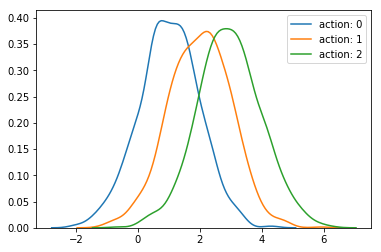

In [85]:
import seaborn as sns
for i in range(3):
    sns.kdeplot([actions[i].act() for x in range(1000)], label="action: " + str(i))
plt.legend();

We try running the above experiment for different epsilon values to see how differente exploration / exploitation values affect the cumulative reward. We expect the returned value functions for the different actions to approximate the mean value that the actions are created with.

In [86]:
def run_experiment(actions, epsilon, steps, epsilon_decay=1):
    """
    Run an experiment assuming we don't know about the rewards the actions return
    """
    action_count = len(actions)
    # N represents the number of time each action has been tried
    N = np.zeros(action_count)
    # V represents the value of an action
    V = np.zeros(action_count)
    # accumulated rewards
    total_average_reward = 0
    running_mean_reward = np.zeros(steps)

    for i in range(steps):
        # epsilon greedy for explore / exploit
        r = np.random.random()
        if r < epsilon:
            action_index = np.random.randint(action_count)
        else:
            action_index = np.argmax(V)

        action = actions[action_index]
        reward = action.act()

        # Update times action taken (N)
        N[action_index] += 1
        # Update value (V) in an incremental fashion, to better approximate the true mean.
        V[action_index] = V[action_index] + (1 / N[action_index]) * (reward - V[action_index])

        # Calculate total average reward incrementally and save for plotting
        total_average_reward = total_average_reward + (1 / (i+1)) * (reward - total_average_reward)
        running_mean_reward[i] = total_average_reward

    return V, running_mean_reward

In [87]:
action_values_0_01, running_mean_reward_0_01 = run_experiment(actions, 0.01, steps)
print(action_values_0_01)

action_values_0_05, running_mean_reward_0_05 = run_experiment(actions, 0.05, steps)
print(action_values_0_05)

action_values_0_1, running_mean_reward_0_1 = run_experiment(actions, 0.1, steps)
print(action_values_0_1)

[0.88482588 1.99407433 2.99425966]
[1.02386658 2.01826845 2.99965007]
[0.9962669  2.0217531  3.00708159]


Plotting the average reward over time, we see that this approaches the optimal value of 3 (note you would need to run this multiple times to account for different random seed values). Larger values of epsilon that allow more exploration seem to reach higher values quicker, but the smaller epsilon values give better results one we have start reaching an optimal solution as we are less likely to take one of the other less optimal actions

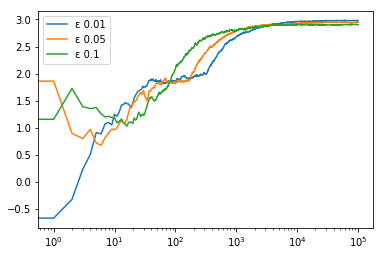

In [88]:
plt.plot(np.ones(steps) * running_mean_reward_0_01, label="ε 0.01")
plt.plot(np.ones(steps) * running_mean_reward_0_05, label="ε 0.05")
plt.plot(np.ones(steps) * running_mean_reward_0_1, label="ε 0.1")
plt.xscale('log')
plt.legend()
plt.show()

### Decaying epsilon
To take advantage of the above difference in epsilon values we might want to start with larger epsilon values and the decay or reduce this over time so we move from an exploration to exploitation based strategy over time as the value of each action starts to better approximate the mean.

In [89]:
action_values_0_1_99, running_mean_reward_0_1_99 = run_experiment(actions, 0.1, steps, 0.99)
print(action_values_0_1_99)

action_values_0_1_9, running_mean_reward_0_1_9 = run_experiment(actions, 0.1, steps, 0.9)
print(action_values_0_1_9)

[0.99062316 1.98514356 3.00169404]
[0.99174714 1.99565967 3.00054415]


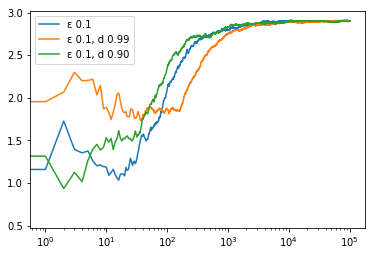

In [90]:
plt.plot(np.ones(steps) * running_mean_reward_0_1, label="ε 0.1")
plt.plot(np.ones(steps) * running_mean_reward_0_1_99, label="ε 0.1, d 0.99")
plt.plot(np.ones(steps) * running_mean_reward_0_1_9, label="ε 0.1, d 0.90")
plt.xscale('log')
plt.legend()
plt.show()

# Upper Conﬁdence Bound (UCB)
UCB-1 is based on the principle of optimism in the face of uncertainty so the more uncertain we are about an arm, the more important it becomes to explore that arm. It uses the notion of uncertainty to choose epsilon value equal to the upper confidence bound and then just exploit. 

In [91]:
import math

def run_experiment_ucb(actions, steps):
    """
    Run an experiment assuming we don't know about the rewards the actions return
    """
    action_count = len(actions)
    # N represents the number of time each action has been tried
    N = np.zeros(action_count)
    # V represents the value of an action
    V = np.zeros(action_count)
    # accumulated rewards
    total_average_reward = 0
    running_mean_reward = np.zeros(steps)

    for i in range(steps):
        # USB1 for explore / exploit
        action_index = 0
        max_upper_bound = 0
        for a in range(0, action_count):
            if (N[a] > 0):
                delta_i = math.sqrt(2 * math.log(i+1) / N[a])
                upper_bound = V[a] + delta_i
            else:
                upper_bound = 1e400
                
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                action_index = a

        action = actions[action_index]
        reward = action.act()
        
        # Update times action taken (N)
        N[action_index] += 1
        # Update value (V) in an incremental fashion, to better approximate the true mean.
        V[action_index] = V[action_index] + (1 / N[action_index]) * (reward - V[action_index])

        # Calculate total average reward incrementally and save for plotting
        total_average_reward = total_average_reward + (1 / (i+1)) * (reward - total_average_reward)
        running_mean_reward[i] = total_average_reward

    return V, running_mean_reward

In [92]:
action_values_ucb, running_mean_reward_ucb = run_experiment_ucb(actions, steps)
print(action_values_ucb)

[1.00010289 1.86366583 3.00497439]


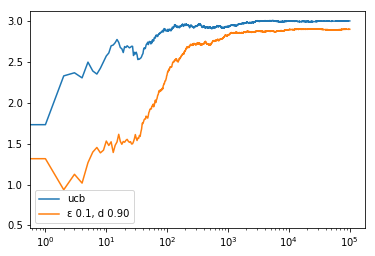

In [93]:
plt.plot(np.ones(steps) * running_mean_reward_ucb, label="ucb")
plt.plot(np.ones(steps) * running_mean_reward_0_1_9, label="ε 0.1, d 0.90")
plt.xscale('log')
plt.legend()
plt.show()

# Non Stationary

References:
Xxx

# Example - Advertising Click Through Rate (CTR) Optimization
Suppose an advertising company is running 10 different ads targeted towards a similar set of population on a webpage. We have results for which ads were clicked by a user here. Each column index represents a different ad. We have a 1 if the ad was clicked by a user, and 0 if it was not.

We want to learn which adverts are most likely to be clicked and show those. In this problem Ad #5 (index 4) is the optimal ad

In [94]:
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('MultiArmedBandit-Ads-Optimisation.csv')
dataset.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


## Random Selection
Baseline using random selection - as we aren't learning anything we don't expectit to smartly select any ad which is giving the maximum return. We also see that the optimal ad isn't selected with any higher probability than others.

In [95]:
# Implementing Random Selection
import random
steps = 10000
action_count = 10
ads_selected = []
total_reward = 0
for i in range(0, steps):
    ad = random.randrange(action_count)
    
    ads_selected.append(ad)
    reward = dataset.values[i, ad]
    total_reward += reward

In [96]:
print("Total Reward:", total_reward)
pd.Series(ads_selected).tail(1000).value_counts(normalize=True)

Total Reward: 1247


0    0.115
7    0.114
8    0.112
6    0.111
4    0.101
5    0.100
1    0.097
2    0.087
9    0.084
3    0.079
dtype: float64

## UCB1 Implementation
UCB1 Gives a much higher reward and also currectly selects the optimal ad with a much higher frequency.

In [97]:
# Implementing UCB
import math
steps = 10000
action_count = 10
ads_selected = []
numbers_of_selections = np.zeros(action_count)
sums_of_reward = np.zeros(action_count)
total_reward = 0

for n in range(0, steps):
    ad = 0
    max_upper_bound = 0
    for i in range(0, action_count):
        if (numbers_of_selections[i] > 0):
            average_reward = sums_of_reward[i] / numbers_of_selections[i]
            delta_i = math.sqrt(2 * math.log(n+1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i
        else:
            upper_bound = 1e400
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i
    ads_selected.append(ad)
    numbers_of_selections[ad] += 1
    reward = dataset.values[n, ad]
    sums_of_reward[ad] += reward
    total_reward += reward

In [98]:
print("Total Reward:", total_reward)
pd.Series(ads_selected).tail(1000).value_counts(normalize=True)

Total Reward: 2125


4    0.771
0    0.106
7    0.034
3    0.034
2    0.026
6    0.007
1    0.007
8    0.006
9    0.005
5    0.004
dtype: float64